In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
from PIL import Image

In [2]:
# Set up some global variables
USE_GPU = True  

if USE_GPU:
    device = '/device:GPU:0'
else:
    device = '/cpu:0'

# Constant to control how often we print when training models
print_every = 100

print('Using device: ', device)

Using device:  /device:GPU:0


INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


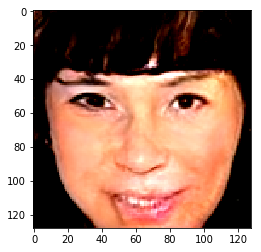

In [3]:
generator = hub.Module("https://tfhub.dev/google/progan-128/1")

with tf.device(device):
    latent = tf.placeholder(tf.float32, shape=(1, 512))
    z = latent
    np.random.seed(4872)
    latent_np = np.random.uniform(low=-1.0, high=1.0, size=(1, 512))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    z_np = sess.run(z, feed_dict={latent: np.reshape(latent_np, (1,512))})
    img = generator(z_np).eval()
    img = (img * 255).astype(np.uint8)
    
img = img.reshape((128, 128, 3))
plt.imshow(img)


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
True


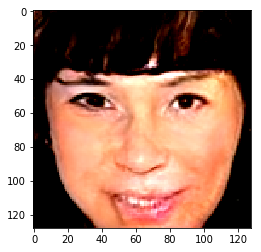

In [4]:
# Check if the same z_np will give the same image
tf.reset_default_graph()
generator = hub.Module("https://tfhub.dev/google/progan-128/1")

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    img = generator(z_np).eval()
    img = (img * 255).astype(np.uint8)
    
img = img.reshape((128, 128, 3))
plt.imshow(img)

print(np.allclose(latent_np, z_np))

In [5]:
np.save("./RecoverGANlatentVector/interpolation_from_start/zp_start.npy", latent_np) # or z_np, which is the same
Image.fromarray(img).save("./RecoverGANlatentVector/interpolation_from_start/foo_00.png")

True


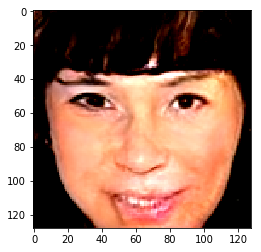

In [6]:
latent_check = np.load("./RecoverGANlatentVector/interpolation_from_start/zp_start.npy")
print(np.allclose(latent_np, latent_check))
 
img_check = Image.open("./RecoverGANlatentVector/interpolation_from_start/foo_00.png")
plt.imshow(img_check)

In [9]:
#!/usr/bin/env python3

# Given an image (possibly generated by the GAN)
# this scripts tries to recover its latent vector.
#
# The algorithm is based on the ICLR 17 workshop paper:
# https://openreview.net/forum?id=HJC88BzFl
# Precise Recovery of Latent Vectors from Generative Adversarial Networks
# by Zachary C. Lipton, and Subarna Tripathi

# It requires:
# - a starting image, ./interpolation_from_start/foo_00.png
# - its latent vector (optional) ./interpolation_from_start/zp_start.npy


folder = "./RecoverGANlatentVector/interpolation_from_start/"
# Choose a random starting point
zp = tf.Variable(np.random.uniform(low=-1.0, high=1.0, size=(1,512)), dtype=tf.float32)
# Or if we know the original latent vector, we can start from it
start_zp = np.load(folder + "zp_start.npy")
print(np.allclose(start_zp, z_np))
# zzp = np.empty((1,512))
# zzp[0] = start_zp
# zp = tf.Variable(zzp, dtype=tf.float32)

# Load the image for which we want to recover the latent vector
# and crete an appropriate tensor for it
start_img = Image.open(folder + "foo_00.png")
start_img.resize((128, 128), Image.ANTIALIAS)
start_img_np = np.array(start_img)/255
fz = tf.Variable(start_img_np, tf.float32)
fz = tf.expand_dims(fz, 0)
fz = tf.cast(fz,tf.float32)
print(fz)

# Define the optimization problem
generator = hub.Module("https://tfhub.dev/google/progan-128/1")
fzp = generator(zp)
loss = tf.losses.mean_squared_error(labels=fz, predictions=fzp)

# Decayed gradient descent
global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 0.99
learning_rate = tf.train.exponential_decay(starter_learning_rate,
                                           global_step,
                                           10000, 0.005)
opt = tf.train.GradientDescentOptimizer(learning_rate)
# Optimize on the variable zp
train = opt.minimize(loss, var_list=zp, global_step=global_step)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
for i in range(10000): # Use more iterations (10000)
  # If we know the original latent vector, we can also compute
  # how far the recovered vector is from it
  _, loss_value, zp_val, eta = sess.run((train, loss, zp, learning_rate))
  z_loss = np.sqrt(np.sum(np.square(zp_val - start_zp))/len(zp_val[0]))
  if i%100 == 0:
      print("%03d) eta=%03f, loss = %f, z_loss = %f" % (i, eta, loss_value, z_loss))
# Save the recovered latent vector
#zp_val = sess.run(zp)
np.save(folder + "zp_rec", zp_val)

# Print out the corresponding image out of the recovered
# latent vector
imgs = sess.run(generator(zp))
imgs = (imgs * 255).astype(np.uint8)
Image.fromarray(imgs[0]).save(folder + "foo_rec.png")

True
Tensor("Cast_2:0", shape=(1, 128, 128, 3), dtype=float32)
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
000) eta=0.990000, loss = 0.190072, z_loss = 0.831566
100) eta=0.938912, loss = 0.046361, z_loss = 0.825922
200) eta=0.890460, loss = 0.032305, z_loss = 0.822148


KeyboardInterrupt: 

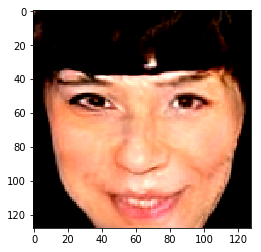

In [65]:
img_rec = Image.open("./RecoverGANlatentVector/interpolation_from_start/foo_rec.png")
plt.imshow(img_rec)

In [66]:
print(zp_val)

[[  1.03219724e+00  -3.97080362e-01   7.40918815e-01  -5.18482506e-01
   -4.14026648e-01  -6.09360993e-01   1.18236141e-02  -4.22111362e-01
   -1.99111607e-02   1.58704609e-01   5.92567623e-01  -5.03553189e-02
    7.94747233e-01   7.89455533e-01  -2.50913769e-01  -9.24865454e-02
    5.71880937e-01  -1.57063752e-01   8.09530258e-01   2.38642380e-01
    1.26642942e-01  -6.90579891e-01  -1.74087644e-01   6.99833453e-01
    2.00230926e-01   4.31930631e-01   1.48489609e-01  -9.86698866e-02
    2.70539820e-01   1.74253926e-01  -1.85121715e-01  -3.91393453e-01
   -4.61548448e-01   6.08969390e-01   8.32369804e-01  -7.05553770e-01
    7.36079454e-01  -5.80094397e-01  -2.03033969e-01   1.72893196e-01
    1.14234045e-01  -5.39696753e-01   5.87318718e-01  -5.71275771e-01
   -4.50747162e-01   3.31506819e-01  -8.76366436e-01   1.29791070e-02
    5.85814118e-01   3.83577108e-01   5.80338538e-01  -2.56922804e-02
   -5.42877391e-02   4.61191833e-01  -4.48897704e-02  -2.03876123e-02
   -2.68396884e-01  

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


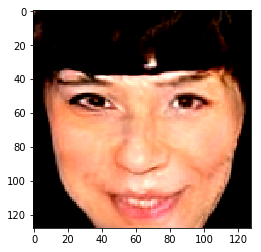

In [67]:
# Generate the image from zp_val
tf.reset_default_graph()
generator = hub.Module("https://tfhub.dev/google/progan-128/1")

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    img = generator(zp_val).eval()
    img = (img * 255).astype(np.uint8)
    
img = img.reshape((128, 128, 3))
plt.imshow(img)

Number of greater: 14  percentage: 2.734375
Number of smaller: 14  percentage: 2.734375


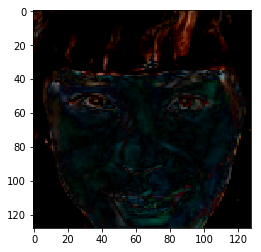

In [68]:
# see how many elements of zp_val are not in interval [-1,1]
# and plot the difference image

greater = np.array(zp_val >= 1.0)
num_greater = np.sum(greater.astype(np.uint8))

smaller = np.array(zp_val <= -1.0)
num_smaller = np.sum(greater.astype(np.uint8))

print("Number of greater:", num_greater, " percentage:", num_greater * 100 / 512)
print("Number of smaller:", num_smaller, " percentage:", num_smaller * 100 / 512)

img1 = np.array(img_rec) / 255
img2 = np.array(start_img) / 255
diff = np.abs(img2 - img1)
plt.imshow(diff)

In [60]:
# now with stochastic clipping
tf.reset_default_graph()

folder = "./RecoverGANlatentVector/interpolation_from_start/"
# Choose a random starting point
zp = tf.Variable(np.random.uniform(low=-1.0, high=1.0, size=(1,512)), dtype=tf.float32)
# Or if we know the original latent vector, we can start from it
start_zp = np.load(folder + "zp_start.npy")
print(np.allclose(start_zp, z_np))
# zzp = np.empty((1,512))
# zzp[0] = start_zp
# zp = tf.Variable(zzp, dtype=tf.float32)

# Load the image for which we want to recover the latent vector
# and create an appropriate tensor for it
start_img = Image.open(folder + "foo_00.png")
start_img.resize((128, 128), Image.ANTIALIAS)
start_img_np = np.array(start_img)/255
fz = tf.Variable(start_img_np, tf.float32)
fz = tf.expand_dims(fz, 0)
fz = tf.cast(fz,tf.float32)

# Define the optimization problem
generator = hub.Module("https://tfhub.dev/google/progan-128/1")
fzp = generator(zp)
loss = tf.losses.mean_squared_error(labels=fz, predictions=fzp)

# Decayed gradient descent
global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 0.99
learning_rate = tf.train.exponential_decay(starter_learning_rate,
                                           global_step,
                                           10000, 0.005)
opt = tf.train.GradientDescentOptimizer(learning_rate)
# Optimize on the variable zp
train = opt.minimize(loss, var_list=zp, global_step=global_step)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
for i in range(10000): # Use more iterations (10000)
    # If we know the original latent vector, we can also compute
    # how far the recovered vector is from it
    _, loss_value, zp_val, eta = sess.run((train, loss, zp, learning_rate))
    #zp_val = np.clip(zp_val, -1, 1)
    zp_val[zp_val>=1] = np.random.uniform(low=0.999, high=1.0)
    zp_val[zp_val<=-1] = np.random.uniform(low=-1.0, high=-0.999)
    z_loss = np.sqrt(np.sum(np.square(zp_val - start_zp))/len(zp_val[0]))
    if i%100 == 0:
        print("%03d) eta=%03f, loss = %f, z_loss = %f" % (i, eta, loss_value, z_loss))
    
    
# Save the recovered latent vector
#zp_val = sess.run(zp)
np.save(folder + "zp_rec_sc", zp_val)

# Print out the corresponding image out of the recovered
# latent vector
imgs = sess.run(generator(zp))
imgs = (imgs * 255).astype(np.uint8)
Image.fromarray(imgs[0]).save(folder + "foo_rec_sc.png")


# stochastic clipping check
greater = np.array(zp_val > 1.0)
num_greater = np.sum(greater.astype(np.uint8))

smaller = np.array(zp_val < -1.0)
num_smaller = np.sum(greater.astype(np.uint8))

print("Number of greater:", num_greater, " percentage:", num_greater * 100 / 512)
print("Number of smaller:", num_smaller, " percentage:", num_smaller * 100 / 512)



True
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
000) eta=0.990000, loss = 0.171283, z_loss = 0.814814
100) eta=0.938912, loss = 0.032409, z_loss = 0.805952
200) eta=0.890460, loss = 0.025623, z_loss = 0.801899
300) eta=0.844509, loss = 0.022603, z_loss = 0.799105
400) eta=0.800929, loss = 0.021160, z_loss = 0.796997
500) eta=0.759598, loss = 0.019901, z_loss = 0.795333
600) eta=0.720399, loss = 0.018717, z_loss = 0.793673
700) eta=0.683224, loss = 0.017366, z_loss = 0.792123
800) eta=0.647967, loss = 0.015493, z_loss = 0.790625
900) eta=0.614529, loss = 0.011896, z_loss = 0.788803
1000) eta=0.582817, loss = 0.008425, z_loss = 0.787063
1100) eta=0.552741, loss = 0.007201, z_loss = 0.785841
1200) eta=0.524218, loss = 0.006673, z_loss = 0.784931
1300) eta=0.497166, loss = 0.006364, z_loss = 0.784166
1400) eta=0.471510, loss = 0.006139, z_loss = 0.783517
1500) eta=0.447178, loss = 0.005953, z_loss = 0.782947
1600) eta=0.424102, loss = 0.005785,

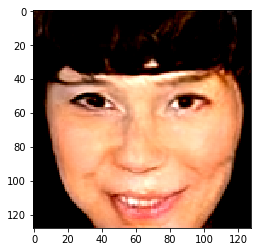

In [61]:
img_rec = Image.open("./RecoverGANlatentVector/interpolation_from_start/foo_rec_sc.png")
plt.imshow(img_rec)

Number of greater: 0  percentage: 0.0
Number of smaller: 0  percentage: 0.0


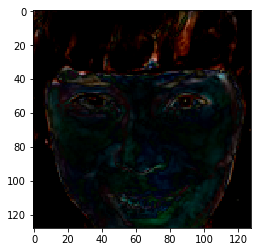

In [62]:
# see how many elements of zp_val are not in interval [-1,1]
# and plot the difference image

greater = np.array(zp_val >= 1.0)
num_greater = np.sum(greater.astype(np.uint8))

smaller = np.array(zp_val <= -1.0)
num_smaller = np.sum(greater.astype(np.uint8))

print("Number of greater:", num_greater, " percentage:", num_greater * 100 / 512)
print("Number of smaller:", num_smaller, " percentage:", num_smaller * 100 / 512)

img1 = np.array(img_rec) / 255
img2 = np.array(start_img) / 255
diff = np.abs(img2 - img1)
plt.imshow(diff)